# Define ML model

This module defines the `model_cal` class, which provides a complete pipeline for modeling
Bioaccumulation Factors (BAF) using Random Forest Regression. It supports data preprocessing,
cross-validation, model training, batch predictions, SHAP-based feature interpretation, and
uncertainty quantification via repeated predictions and confidence intervals.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

class model_cal:
    def __init__(self, datapath='BAFdata/modeldata2.csv') -> None:
        # Load dataset
        self.data = pd.read_csv(datapath, index_col=0)

        # Define feature columns
        self.feature_lis = ['Kow',
                            'trophic level',
                            'Protein (%)',
                            'Concentration in environmental media(ng/L)',
                            'Salinity (‰)',
                            'Temperature(℃)',
                            'groups',
                            'length']

        # Extract features and target variable
        self.X = self.data[self.feature_lis]
        self.y = self.data['BAF']

        # Data preprocessing
        self.LNBAF()  # Log transform
        self.classify_PFAS()  # Classification

    def LNBAF(self):
        # Log transformation
        self.y = self.y.apply(np.log)

    def classify_PFAS(self):
        # 'PFCAs' => 1, 'PFSAs' => 0
        self.X.loc[:, 'groups'] = self.data['groups'].apply(lambda x: 1 if x == 'PFCAs' else 0)

    def build_random_forest(self):
        # Use StratifiedKFold for 5-fold cross-validation
        stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Store R² and MSE for each fold
        r2_scores = []
        mse_scores = []

        # Store predictions for each sample in validation set
        predictions = []

        # Perform 5-fold cross-validation
        for fold, (train_index, test_index) in enumerate(stratified_kf.split(self.X, self.data['groups']), 1):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]

            # Initialize Random Forest model
            rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
            # Train model
            rf_model.fit(X_train, y_train)

            # Predict and calculate R² and MSE
            y_pred = rf_model.predict(X_test)
            r2 = rf_model.score(X_test, y_test)
            mse = mean_squared_error(y_test, y_pred)

            # Store metrics
            r2_scores.append(r2)
            mse_scores.append(mse)

            # Store prediction results
            fold_predictions = pd.DataFrame({
                'sample_index': self.X.iloc[test_index].index,
                'predicted': y_pred,
                'true': y_test
            })
            fold_predictions['fold'] = fold
            predictions.append(fold_predictions)

        # Combine all fold predictions
        all_predictions = pd.concat(predictions, ignore_index=True)

        # Output results
        print(f'R² Scores for each fold: {r2_scores}')
        print(f'Average R² Score: {np.mean(r2_scores)}')
        print(f'Mean Squared Error for each fold: {mse_scores}')
        print(f'Average Mean Squared Error: {np.mean(mse_scores)}')

        return rf_model, all_predictions

    def train_on_full_data(self):
        # Train model on the entire dataset
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(self.X, self.y)
        y_pred = rf_model.predict(self.X)
        r2 = r2_score(self.y, y_pred)
        mse = mean_squared_error(self.y, y_pred)

        # Output evaluation metrics
        print(f'R² Score on Full Data: {r2}')
        print(f'Mean Squared Error on Full Data: {mse}')

        # Save predictions and model
        self.y_pred = y_pred
        self.y_true = self.y
        self.rf_model = rf_model
        return rf_model

    def get_predictions(self):
        """
        Return true and predicted values from training set.
        :return: DataFrame containing true and predicted values
        """
        if not hasattr(self, 'y_pred'):
            raise ValueError("Model not trained yet. Please call train_on_full_data() first.")
        predictions_df = pd.DataFrame({
            'True Values': self.y_true,
            'Predictions': self.y_pred
        })
        return predictions_df

    def predict_new_data(self, X_new):
        """
        Predict new data and return predictions with 95% confidence intervals.
        :param X_new: New data (DataFrame or numpy array) with same features as training data.
        :return: predictions, lower and upper 95% confidence intervals
        """
        if not hasattr(self, 'rf_model'):
            raise ValueError("Model not trained yet. Please call train_on_full_data() first.")

        if isinstance(X_new, pd.DataFrame):
            X_new = X_new[self.feature_lis]

        all_tree_predictions = np.array([tree.predict(X_new) for tree in self.rf_model.estimators_]).T

        predictions_mean = all_tree_predictions.mean(axis=1)
        predictions_std = all_tree_predictions.std(axis=1)

        conf_interval_upper = predictions_mean + 1.96 * predictions_std
        conf_interval_lower = predictions_mean - 1.96 * predictions_std

        return predictions_mean, conf_interval_lower, conf_interval_upper

    def batch_predict(self, df: pd.DataFrame):
        """
        Batch predict for new data. Input original DataFrame, output with prediction results and intervals.
        :param df: Original input DataFrame with columns ['Kow', 'TL', 'Protein', 'Con', 'salinity', 'T_C', 'Groups', 'length']
        :return: DataFrame with predictions and 95% confidence intervals
        """
        transformed_df = self.trans_df(df)

        from tqdm import tqdm
        all_tree_predictions = np.array([tree.predict(transformed_df) for tree in tqdm(self.rf_model.estimators_, desc="Predicting with trees")]).T

        predictions_mean = all_tree_predictions.mean(axis=1)
        predictions_std = all_tree_predictions.std(axis=1)

        conf_interval_upper = predictions_mean + 1.96 * predictions_std
        conf_interval_lower = predictions_mean - 1.96 * predictions_std

        df['pre_LNBAF'] = predictions_mean
        df['conf_interval_lower'] = conf_interval_lower
        df['conf_interval_upper'] = conf_interval_upper

        return df

    def trans_df(self, df: pd.DataFrame):
        """
        Convert input DataFrame into format suitable for model input.
        :param df: Input DataFrame with columns ['Kow', 'TL', 'Protein', 'Con', 'salinity', 'T_C', 'Groups', 'length']
        :return: Transformed DataFrame
        """
        ori_lis = [
            'Kow',
            'TL',
            'Protein',
            'Con',
            'salinity',
            'T_C',
            'Groups',
            'Length'
        ]
        _df = df[ori_lis]
        _df.loc[:, 'Groups'] = _df['Groups'].apply(lambda x: 1 if x == 'PFCAs' else 0)
        _df.columns = self.feature_lis
        return _df

    def run_multiple_times_and_calculate_statistics(self, df: pd.DataFrame, n_runs=100, confidence_level=0.95):
        """
        Run model multiple times and calculate prediction statistics (mean, std, CI).
        :param df: Input DataFrame with original features
        :param n_runs: Number of runs (default 100)
        :param confidence_level: Confidence interval level (default 95%)
        :return: DataFrame with prediction mean and confidence intervals
        """
        transformed_df = self.trans_df(df)

        all_predictions = []
        from tqdm import tqdm
        for _ in tqdm(range(n_runs)):
            rf_model = RandomForestRegressor(n_estimators=100)
            rf_model.fit(self.X, self.y)
            y_pred = rf_model.predict(transformed_df)
            all_predictions.append(y_pred)

        all_predictions = np.array(all_predictions)

        mean_predictions = all_predictions.mean(axis=0)
        std_predictions = all_predictions.std(axis=0)

        z_value = 1.96

        conf_interval_lower = mean_predictions - z_value * std_predictions
        conf_interval_upper = mean_predictions + z_value * std_predictions

        df['pre_LNBAF'] = mean_predictions
        df['conf_interval_lower'] = conf_interval_lower
        df['conf_interval_upper'] = conf_interval_upper

        return df

    def calculate_shap_values(self):
        """
        Calculate SHAP values for features and return importance and plots.
        :return: DataFrame of SHAP values and feature importance
        """
        import shap
        if not hasattr(self, 'rf_model'):
            raise ValueError("Model not trained yet. Please call train_on_full_data() first.")

        explainer = shap.TreeExplainer(self.rf_model)
        shap_values = explainer.shap_values(self.X)

        shap_df = pd.DataFrame(shap_values, columns=self.feature_lis)
        feature_importance = shap_df.abs().mean(axis=0).sort_values(ascending=False)

        print("Feature Importance (based on SHAP values):")
        print(feature_importance)

        self.feature_name_mapping = {
            'Kow': 'Kow',
            'trophic level': 'Trophic Level',
            'Protein (%)': 'Protein Content (%)',
            'Concentration in environmental media(ng/L)': 'Concentration (ng/L)',
            'Salinity (‰)': 'Salinity (‰)',
            'Temperature(℃)': 'Temperature (℃)',
            'groups': 'PFAS Group (PFCAs=1, PFSAs=0)',
            'length': 'Length'
        }
        X_mapped = self.X.rename(columns=self.feature_name_mapping)
        shap.summary_plot(shap_values, X_mapped, plot_type="bar")
        shap.summary_plot(shap_values, X_mapped)

        return shap_df, feature_importance

    def train_and_validate_multiple_seeds(self, n_seeds=10):
        """
        Train and validate the model using multiple random seeds.
        :param n_seeds: Number of seeds (default 10)
        :return: Dictionary of R² and MSE statistics
        """
        all_r2_scores = []
        all_mse_scores = []
        from tqdm import tqdm
        for seed in tqdm(range(n_seeds)):
            rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
            r2_scores = []
            mse_scores = []

            for _ in range(5):
                X_train, X_test, y_train, y_test = train_test_split(
                    self.X, self.y, test_size=0.2, random_state=seed, shuffle=True
                )

                rf_model.fit(X_train, y_train)
                y_pred = rf_model.predict(X_test)
                r2 = r2_score(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)

                r2_scores.append(r2)
                mse_scores.append(mse)

            all_r2_scores.append(np.mean(r2_scores))
            all_mse_scores.append(np.mean(mse_scores))

        avg_r2 = np.mean(all_r2_scores)
        avg_mse = np.mean(all_mse_scores)
        std_r2 = np.std(all_r2_scores)
        std_mse = np.std(all_mse_scores)

        print("\nOverall Statistics:")
        print(f"R²: Mean = {avg_r2}, Std = {std_r2}")
        print(f"MSE: Mean = {avg_mse}, Std = {std_mse}")

        return {
            'r2_scores': all_r2_scores,
            'mse_scores': all_mse_scores,
            'r2_mean': avg_r2,
            'r2_std': std_r2,
            'mse_mean': avg_mse,
            'mse_std': std_mse
        }

    def train_and_validate_single_split(self, chem_cls_type='Abbreviation'):
        """
        Train and validate model with a single stratified split.
        :return: Dictionary containing all training and validation results
        """
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.data['Abbreviation'], random_state=42,
        )

        _X_train, _X_test, _y_train, _y_test = train_test_split(
            self.data[chem_cls_type], self.y, test_size=0.2, stratify=self.data['Abbreviation'], random_state=42
        )

        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)

        y_pred = rf_model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        y_train_pre = rf_model.predict(X_train)

        results = {
            'r2_score': r2,
            'mse': mse,
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_train_pre': y_train_pre,
            'y_test': y_test,
            'y_pred': y_pred,
            'rf_model': rf_model,
            'chem_cls_train': _X_train,
            'chem_cls_test': _X_test
        }

        print(f'R² Score: {r2}')
        print(f'Mean Squared Error: {mse}')

        return results


# Training the model

In [1]:
import pandas as pd

BAF_data = pd.read_excel('BAFdata\\BAF.xlsx')
name_df = pd.read_excel('BAFdata\\name_replace.xlsx')

In [2]:
idc = dict(zip(name_df['old'],name_df['groups']))
lendc = dict(zip(name_df['old'],name_df['length']))

In [3]:
modeldata = BAF_data.copy()
lis = []
llis = []
for x in modeldata['Abbreviation']:
    if x in idc.keys():
        llis.append(lendc[x])
        lis.append(idc[x])
    else:
        lis.append(0)
        llis.append(0)
modeldata['groups'] = lis
modeldata['length'] = llis

In [4]:
md_1 =modeldata[(modeldata['groups']!=0)&(modeldata['Tissue']=='muscle')]

In [5]:
md_2 = modeldata[(modeldata['groups']!=0)&(modeldata['Tissue']=='whole')].copy()
_lis = []
for i in md_2.index:
    if md_2['groups'][i] =='PFCAs':
        _lis.append(md_2['BAF'][i]/2.5)
    elif md_2['groups'][i] == 'PFSAs':
        _lis.append(md_2['BAF'][i]/2.6)
    else:
        raise ValueError('')
md_2['BAF'] = _lis

In [6]:
df_combined = pd.concat([md_1, md_2], axis=0)

In [7]:
df_combined.to_csv('BAFdata/modeldata2.csv')

In [8]:
import pandas as pd
pfosori = pd.read_csv('PFOS_2019.csv')
pfosori.head(1)

,lon,lat,value
0,-18,-80,0.036995


In [9]:
pfos = pd.read_csv('PFOS2010_g_medianinit.csv',index_col=0)
pfos.head(1)

,lat,lon,value,moni_num,neighbor_pois,neighbor_values
0,79,-133,0.01129,0,"[(74, -133), (74, -136), (74, -135), (74, -134)]","[0.009483006816762504, 0.011893311833851509, 0..."


In [10]:
merged = pd.merge(pfosori[['lat', 'lon', 'value']], pfos[['lat', 'lon', 'value']], on=['lat', 'lon'], suffixes=('_ori', '_new'))
merged.head(1)

,lat,lon,value_ori,value_new
0,-80,-18,0.036995,0.028


In [11]:
merged.to_csv('PFOS-2019-ori-new.csv')

## Model Explanation and Result Statistics

In [1]:
from BAFmodel import model_cal
model = model_cal()

Feature Importance (based on SHAP values):
Concentration in environmental media(ng/L)    1.085055
Temperature(℃)                                1.031533
length                                        0.210825
trophic level                                 0.170624
Salinity (‰)                                  0.169921
Kow                                           0.126598
Protein (%)                                   0.119711
groups                                        0.071274
dtype: float64


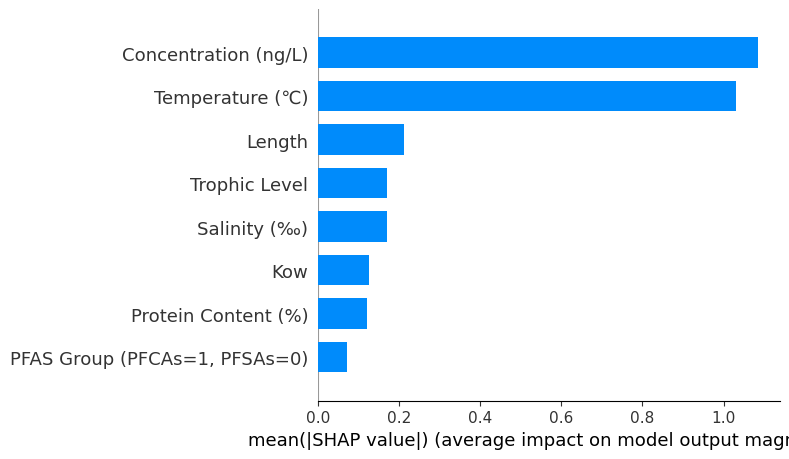

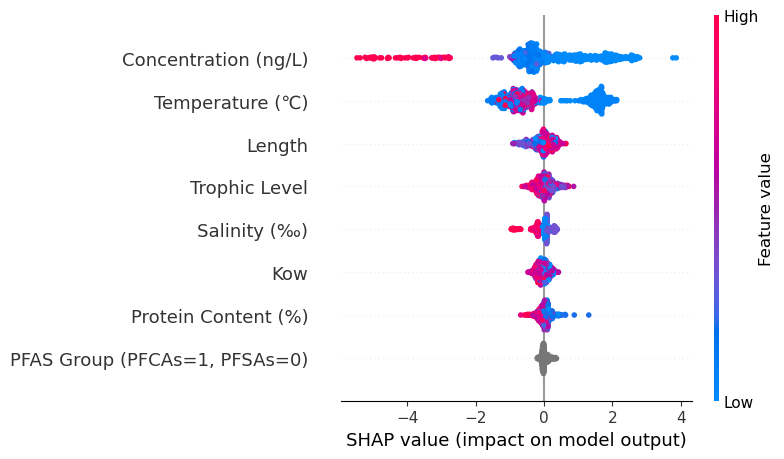

In [10]:
shap_df, feature_importance = model.calculate_shap_values()

In [14]:
import pandas as pd
pre_df = pd.read_csv('BAFdata\\BAF_NEW_DATA.csv')
# pre_df = pd.read_csv('BAFdata/merged_data.csv')

In [15]:
# pre_df = pd.read_csv('BAFdata/merged_data.csv')
pre_df_finish = model.run_multiple_times_and_calculate_statistics(pre_df)
pre_df_finish.describe()

100%|██████████| 100/100 [26:21<00:00, 15.82s/it]


,lat,lon,total_tonnes,kg,year,TL,Protein,salinity,T_C,Kow,Length,Con,pre_LNBAF,conf_interval_lower,conf_interval_upper
count,4.714824e+06,4.714824e+06,4.714824e+06,4.714824e+06,4.714824e+06,4.714824e+06,4.714824e+06,4.714824e+06,4.714824e+06,4.714824e+06,4.714824e+06,4.714824e+06,4.714824e+06,4.714824e+06,4.714824e+06
mean,2.067363e+01,4.325456e+01,9.029858e+01,9.029858e+04,2.014355e+03,3.998262e+00,1.947341e+01,3.425303e+01,1.792738e+01,4.411043e+00,7.570498e+00,1.384198e+00,7.187762e+00,6.871371e+00,7.504153e+00
std,3.606583e+01,9.893040e+01,4.143735e+02,4.143735e+05,4.987385e+00,5.316322e-01,2.118179e+00,2.507585e+00,9.272663e+00,1.411578e+00,1.974438e+00,1.764053e+01,1.254805e+00,1.244355e+00,1.272184e+00
min,-5.800000e+01,-1.790000e+02,6.485800e-12,6.485800e-09,2.009000e+03,2.000000e+00,1.230000e+01,2.549000e+00,-1.894000e+00,1.820000e+00,4.000000e+00,3.000000e-05,-1.327532e+00,-1.527220e+00,-1.132115e+00
25%,-1.400000e+01,-4.500000e+01,1.028447e-01,1.028447e+02,2.009000e+03,3.700000e+00,1.800000e+01,3.321300e+01,1.018500e+01,3.480000e+00,6.000000e+00,8.559817e-03,6.511226e+00,6.225535e+00,6.815382e+00
50%,2.800000e+01,9.400000e+01,2.490477e+00,2.490477e+03,2.019000e+03,4.200000e+00,1.940000e+01,3.462200e+01,1.950600e+01,4.490000e+00,8.000000e+00,3.000000e-02,7.229118e+00,6.895964e+00,7.574412e+00
75%,5.200000e+01,1.300000e+02,2.548901e+01,2.548901e+04,2.019000e+03,4.400000e+00,2.070000e+01,3.551400e+01,2.683900e+01,5.480000e+00,9.000000e+00,1.350238e-01,8.168029e+00,7.793618e+00,8.523740e+00
max,8.200000e+01,1.800000e+02,3.438958e+04,3.438958e+07,2.019000e+03,4.900000e+00,2.420000e+01,3.934700e+01,3.277500e+01,6.820000e+00,1.100000e+01,1.278378e+03,1.150236e+01,1.128273e+01,1.176987e+01


In [16]:
pre_df_finish.to_csv('BAFdata/BAF_NEW_DATA_preBAF.csv')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde, linregress, f, stats
from statistics import mean
from sklearn.metrics import mean_squared_error
import math

def plot_regression(x, y, title="\ntrain\n", xlabel="Observation", ylabel="Prediction"):
    """
    Generate a regression plot with scatter density and statistical annotations.

    Parameters:
    - x: pandas.Series, observations (log-transformed if needed).
    - y: pandas.Series, predictions (log-transformed if needed).
    - title: str, title of the plot.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.

    Returns:
    - fig, ax: Matplotlib figure and axis objects.
    """
    fig, ax = plt.subplots(figsize=(13, 10), dpi=256, facecolor='white')

    # Calculate density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Fit line
    slope, intercept = linregress(x, y)[:2]
    lmfit = (slope * x) + intercept
    r2 = r2_score(x, y)
    RMSE = sqrt(mean_squared_error(x, y))

    # T-test and variance F-test
    t, p = stats.ttest_ind(x, y, equal_var=False)
    F = x.var() / y.var()
    df1 = len(x) - 1
    df2 = len(y) - 1
    p_value = 1 - 2 * abs(0.5 - f.cdf(F, df1, df2))
    p_print = 'p<0.0001' if p_value < 0.001 else f'p = {p_value:.2f}'

    # Regression line
    def get_regression_line(real, pred):
        def slope(xs, ys):
            m = (((mean(xs) * mean(ys)) - mean(xs * ys)) / ((mean(xs) * mean(xs)) - mean(xs * xs)))
            b = mean(ys) - m * mean(xs)
            return m, b

        k, b = slope(real, pred)
        regression_line = [(k * a) + b for a in range(-5, 18)]
        return regression_line, k, b

    cb = ax.scatter(x, y, s=15, c=z, zorder=1, cmap='jet')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, zorder=2, color='black', linewidth=2, linestyle=(0, (5, 10)))
    regression_line, reg_slope, reg_intercept = get_regression_line(x, y)
    ax.plot([i for i in range(-5, 18)], regression_line, 'k-', lw=1, zorder=3)

    # Annotations
    ax.text(-4.7, 15.8, f'Ln(Prediction) = {reg_slope:.2f} × Ln(Observation) + {reg_intercept:.2f}',
            fontsize=27, family='Times New Roman')
    ax.text(-4.7, 14.3, p_print, fontsize=27, family='Times New Roman')
    ax.text(-4.7, 12.8, f'RMSE = {RMSE:.2f}', fontsize=27, family='Times New Roman')
    ax.text(-4.7, 11.3, f'R$^{{\mathregular{{2}}}}$ = {r2:.2f}', fontsize=27, family='Times New Roman')

    # Labels and ticks
    ax.set_ylabel(ylabel, fontsize=25, fontweight='semibold', family='Times New Roman')
    ax.set_xlabel(xlabel, fontsize=25, fontweight='semibold', family='Times New Roman')
    ax.set_ylim((-5, 17))
    ax.set_xlim((-5, 17))
    ticks = [0, math.log(1000), math.log(1000000)]
    ticket = ['1E00', '1E03', '1E06']
    ax.set_yticks(ticks, ticket, family='Times New Roman')
    ax.set_xticks(ticks, ticket, family='Times New Roman')
    ax.tick_params(labelsize=15)

    # Colorbar
    colorbar = fig.colorbar(cb)
    for l in colorbar.ax.yaxis.get_ticklabels():
        l.set_family('Times New Roman')
    colorbar.ax.tick_params(labelsize=15)
    colorbar.set_label('Scatter Density', fontsize=20, family='Times New Roman')

    # Title
    ax.set_title(title, fontsize=25, fontweight='semibold', family='Times New Roman')

    return fig, ax



<>:66: SyntaxWarning: invalid escape sequence '\m'
<>:66: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Yuzhe Li\AppData\Local\Temp\ipykernel_46384\966934768.py:66: SyntaxWarning: invalid escape sequence '\m'
  ax.text(-4.7, 11.3, f'R$^{{\mathregular{{2}}}}$ = {r2:.2f}', fontsize=27, family='Times New Roman')


In [1]:
from BAFmodel import model_cal
model = model_cal()
rf_model, all_predictions = model.build_random_forest()
all_predictions['Family'] = model.data['Family'][all_predictions['sample_index']]

In [3]:
import pandas as pd
results =model.train_and_validate_single_split(chem_cls_type='Family')
print(pd.unique(results['chem_cls_test']).__len__())
print(pd.unique(results['chem_cls_train']).__len__())

40
51


In [ ]:
from BAFmodel import model_cal
model = model_cal()
rf_model, all_predictions = model.build_random_forest()
all_predictions['Family'] = model.data['Family'][all_predictions['sample_index']]

Family 'nan' has less than 3 data points. Skipping normality test.
Family 'Pomatomide' has less than 3 data points. Skipping normality test.
Family 'Moronidae' has less than 3 data points. Skipping normality test.
Family 'Scatophagidae' has less than 3 data points. Skipping normality test.
Family 'Paralichthyidae' has less than 3 data points. Skipping normality test.


C:\Users\Yuzhe Li\AppData\Local\Temp\ipykernel_28588\992226807.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  box = sns.boxplot(
C:\Users\Yuzhe Li\AppData\Local\Temp\ipykernel_28588\992226807.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\Yuzhe Li\AppData\Local\Temp\ipykernel_28588\992226807.py:71: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


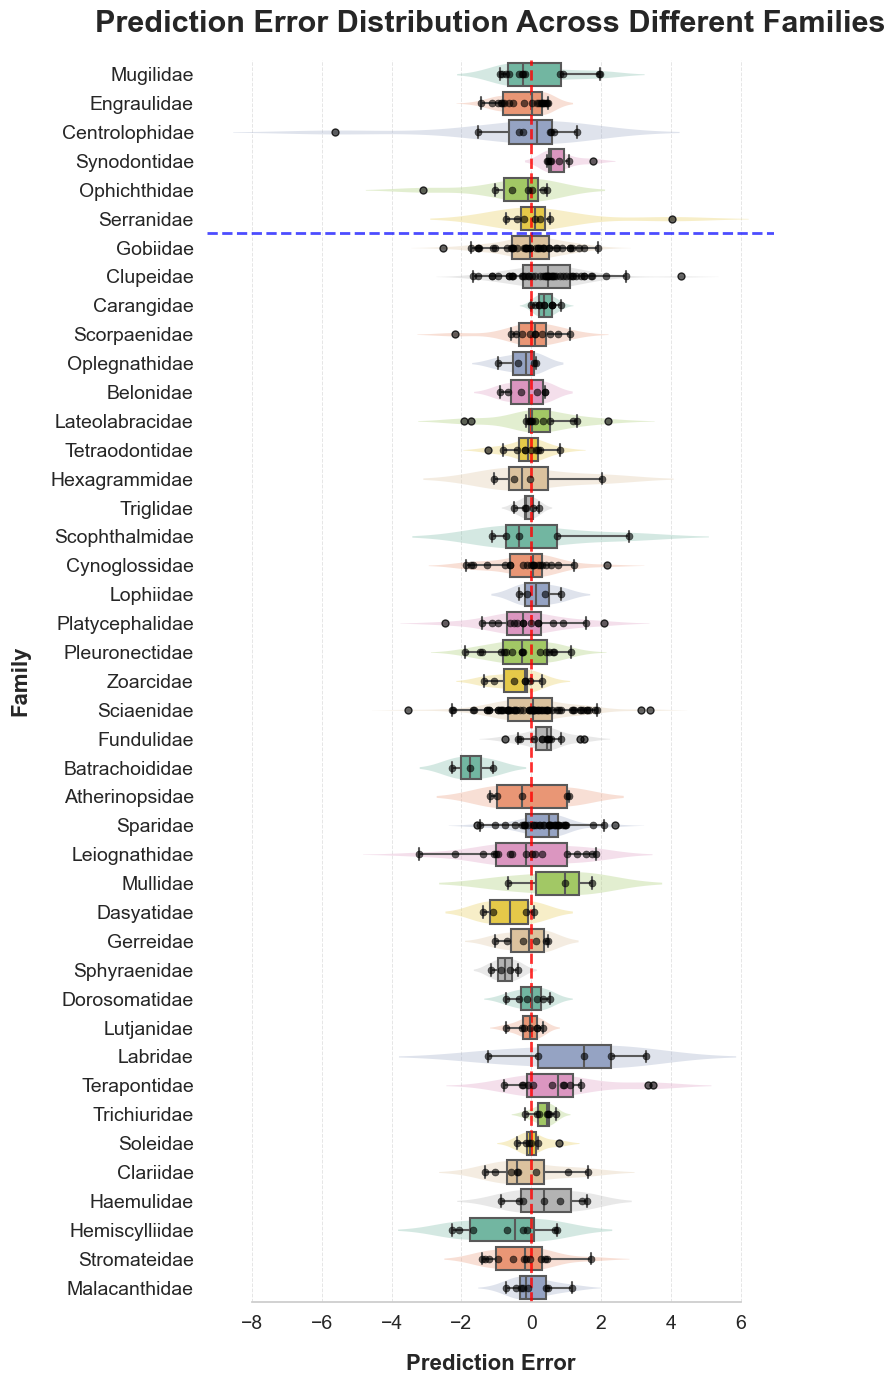

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import shapiro

dic = {
    'error': all_predictions['predicted'] - all_predictions['true'],
    'class': all_predictions['Family']
}

df = pd.DataFrame(dic)

p_values = {}
for family in df['class'].unique():
    family_errors = df[df['class'] == family]['error']
    
    if len(family_errors) < 3:
        print(f"Family '{family}' has less than 3 data points. Skipping normality test.")
        p_values[family] = None
    else:
        stat, p_value = shapiro(family_errors)
        p_values[family] = p_value

normal_families = [family for family, p in p_values.items() if p is not None and p >= 0.05]
non_normal_families = [family for family, p in p_values.items() if p is not None and p < 0.05]
ordered_families = non_normal_families + normal_families

sns.set_theme(
    style="whitegrid",
    context="notebook",
    palette="deep"
)

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(8, 14))

box = sns.boxplot(
    y='class', x='error', data=df,
    palette="Set2",
    linewidth=1.5,
    fliersize=5,
    showfliers=True,
    order=ordered_families
)

sns.violinplot(
    y='class', x='error', data=df,
    palette="Set2",
    alpha=0.3,
    linewidth=0,
    order=ordered_families
)

sns.stripplot(
    y='class', x='error', data=df,
    color='black', alpha=0.6, jitter=False,
    size=5, edgecolor='gray', linewidth=0.5,
    order=ordered_families
)

plt.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.8)

if non_normal_families:
    last_non_normal_family = non_normal_families[-1]
    plt.axhline(y=ordered_families.index(last_non_normal_family) + 0.5, color='blue', linestyle='--', linewidth=2, alpha=0.7)

plt.title('Prediction Error Distribution Across Different Families', fontsize=22, weight='bold', pad=20)
plt.xlabel('Prediction Error', fontsize=16, weight='bold', labelpad=15)
plt.ylabel('Family', fontsize=16, weight='bold', labelpad=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, axis='x', linestyle='--', linewidth=0.7, alpha=0.5)

sns.despine(trim=True, left=True)

plt.tight_layout()

plt.savefig('box_with_points_improved_academic_shapiro_with_line.png', dpi=600, bbox_inches='tight')

plt.show()


In [25]:
# Example usage:
x = results['y_train']
y = results['y_train_pre']
# plot_regression(x, y,title='\ntrain\n')

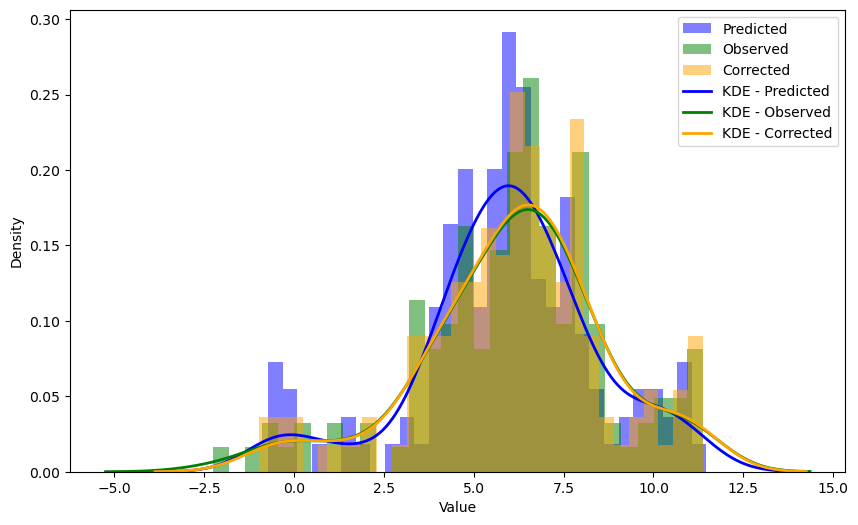

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


predicted = results['y_pred']
observed = results['y_test']


def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

x_pred, y_pred = ecdf(predicted)
x_obs, y_obs = ecdf(observed)


def empirical_distribution_matching(predicted, observed):
    ecdf_pred = stats.rankdata(predicted, method="max") / len(predicted)
    observed_sorted = np.sort(observed)
    corrected = np.interp(ecdf_pred, np.linspace(0, 1, len(observed_sorted)), observed_sorted)
    return corrected

corrected = empirical_distribution_matching(predicted, observed)


plt.figure(figsize=(10, 6))


plt.hist(predicted, bins=30, alpha=0.5, label="Predicted", density=True, color='blue')
plt.hist(observed, bins=30, alpha=0.5, label="Observed", density=True, color='green')
plt.hist(corrected, bins=30, alpha=0.5, label="Corrected", density=True, color='orange')


sns.kdeplot(predicted, color='blue', linestyle='-', label='KDE - Predicted', linewidth=2)
sns.kdeplot(observed, color='green', linestyle='-', label='KDE - Observed', linewidth=2)
sns.kdeplot(corrected, color='orange', linestyle='-', label='KDE - Corrected', linewidth=2)


plt.legend()
# plt.title("Empirical Distribution Matching with KDE")
plt.xlabel("Value")
plt.ylabel("Density")


plt.show()


C:\Users\Yuzhe Li\AppData\Local\Temp\ipykernel_36180\3532345842.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
C:\Users\Yuzhe Li\AppData\Local\Temp\ipykernel_36180\3532345842.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
C:\Users\Yuzhe Li\AppData\Local\Temp\ipykernel_36180\3532345842.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = results.pvalues[1] 

(<Figure size 3328x2560 with 2 Axes>,
 <Axes: title={'center': '\nTest (corrected)\n'}, xlabel='Observation', ylabel='Prediction'>)

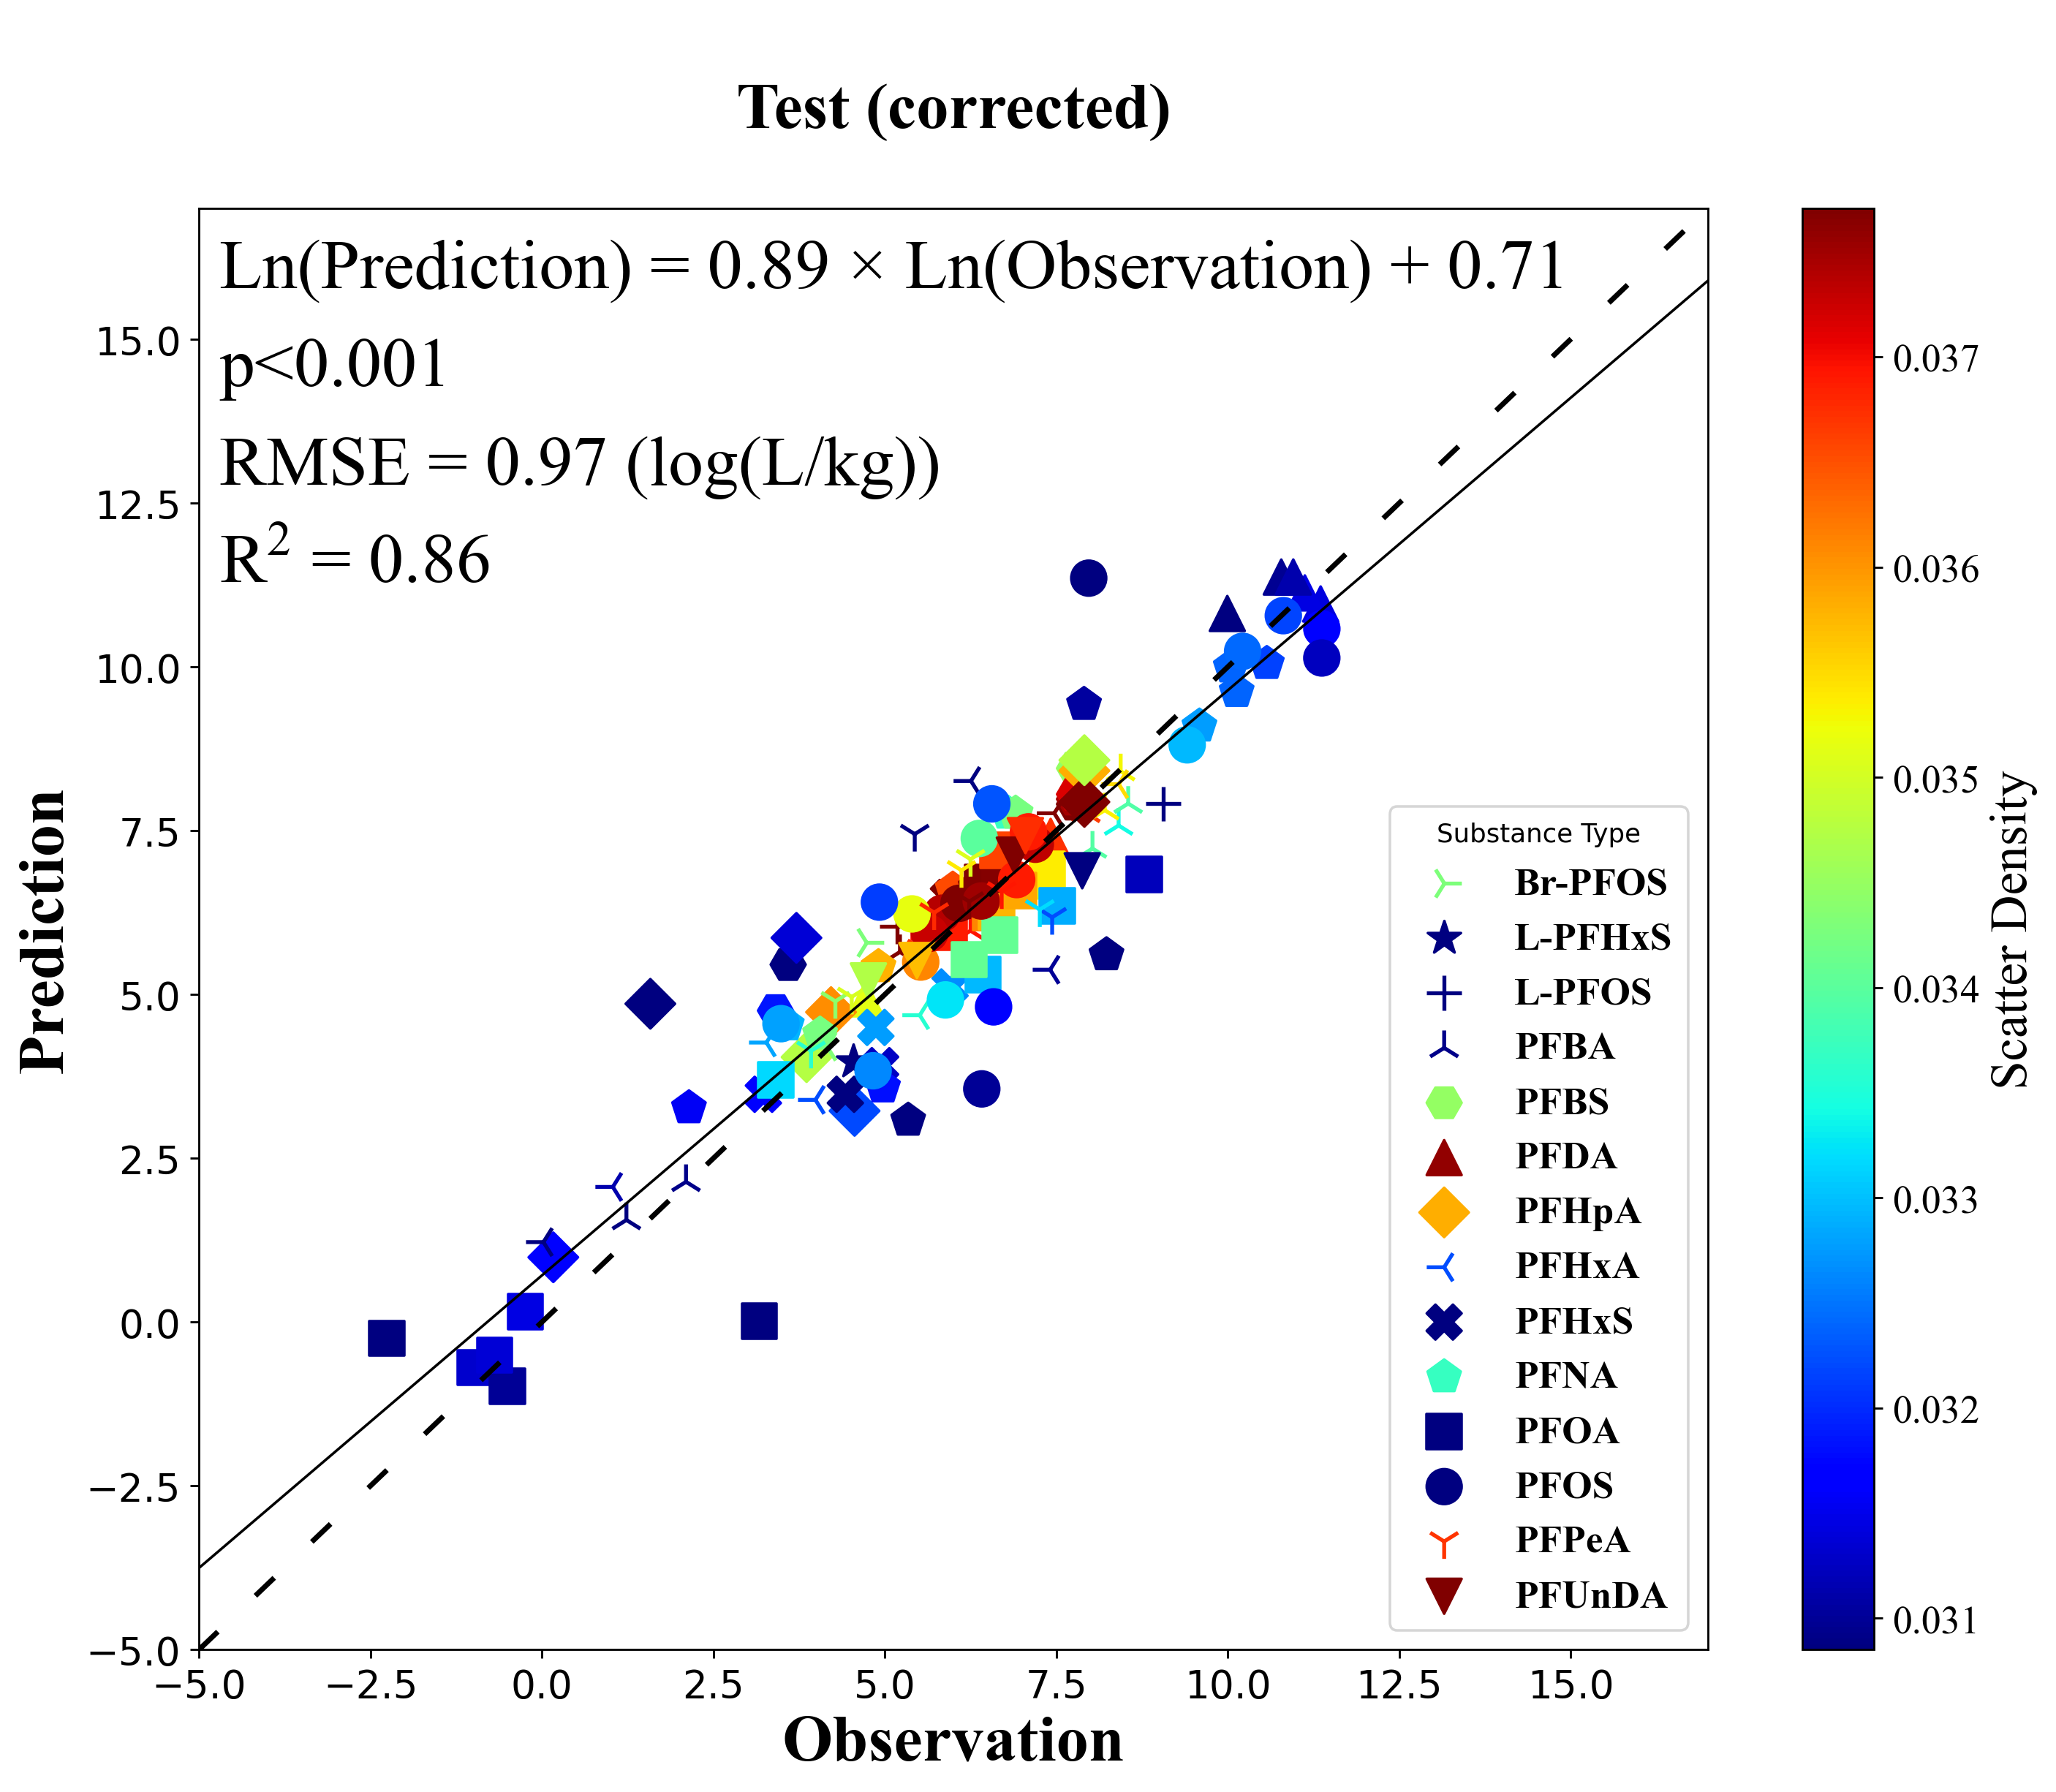

In [45]:
# Example usage:
plot_regression(observed, corrected,results['chem_cls_test'],title='\nTest (corrected)\n')